In [1]:
!pip install --upgrade pip
!pip install tensorflow

  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/47/6a/453160888fab7c6a432a6e25f8afe6256d0d9f2cbd25971021da6491d899/pip-23.3.1-py3-none-any.whl.metadata
Using cached pip-23.3.1-py3-none-any.whl (2.1 MB)


ERROR: To modify pip, please run the following command:
C:\Users\vdako\anaconda3\envs\sam-model-env\python.exe -m pip install --upgrade pip


  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/fb/59/3eb58629e3749d9f4fc1e522487af369f9bd4c451f465d3054961fab6bf8/tensorflow-2.13.1-cp38-cp38-win_amd64.whl.metadata
INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/5b/6f/8b125d126d54061c0be610b135aaf2f8960f55c2e185ac32445e4a5012d5/tensorflow-2.13.0-cp38-cp38-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.13.0 from https://files.pythonhosted.org/packages/38/ba/dd4d998a852451e98dc009ecb208bbb0eeb0c8252dc35b7c4e1050762b36/tensorflow_intel-2.13.0-cp38-cp38-win_amd64.whl.metadata
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Obtaining dependency information for flatbuffers>=23.1.21 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
supervision 0.12.0 requires pillow<9.0.0,>=8.4.0, but you have pillow 10.0.0 which is incompatible.


In [1]:
import sys
import tensorflow.keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print(f"Tensor Flow Version: {tf.__version__}")
print()
print(f"Python {sys.version}")
print("GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

Tensor Flow Version: 2.13.0

Python 3.8.17 (default, Jul  5 2023, 20:44:21) [MSC v.1916 64 bit (AMD64)]
GPUs Available:  0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [8]:
import pickle
dict = pickle.load(open('california-housing-dataset.pkl', 'rb'))
x_train, y_train = dict['x_train'], dict['y_train']
x_test, y_test = dict['x_test'], dict['y_test']


## Dataset Exploration


In [4]:
features = ['MedInc', 'HouseAge' ,'AveRooms' ,'AveBedrms' ,'Population', 'AveOccup' ,'Latitude' ,'Longitude' ]

def show_dataset_min_and_max(x, y, features):
    for i in range(len(features)):
        a = x[:,i]
        print('{}; [{}, {}]'.format(features[i],min(a), max(a),))
        print('Datatype: {}'.format(a.dtype))
    print('\nMax Price: {}; Min Price: {}'.format(max(y), min(y[:])))
    

#### Non-Normalized Values


In [5]:
show_dataset_min_and_max(x_train, y_train, features)

MedInc; [0.4999, 15.0001]
Datatype: float64
HouseAge; [1.0, 52.0]
Datatype: float64
AveRooms; [0.8461538461538461, 141.9090909090909]
Datatype: float64
AveBedrms; [0.3333333333333333, 34.06666666666667]
Datatype: float64
Population; [5.0, 35682.0]
Datatype: float64
AveOccup; [0.6923076923076923, 1243.3333333333333]
Datatype: float64
Latitude; [32.54, 41.95]
Datatype: float64
Longitude; [-124.35, -114.31]
Datatype: float64

Max Price: 5.00001; Min Price: 0.14999


#### Normalized Values


In [6]:
def normalize(x):
    col_max = np.max(x, axis=0)
    col_min = np.min(x, axis=0)
    normX = np.divide(x - col_min, col_max - col_min)
    return normX

x_train_n = normalize(x_train)
y_train_n = normalize(y_train)

In [7]:
show_dataset_min_and_max(x_train_n, y_train_n, features)

MedInc; [0.0, 1.0]
Datatype: float64
HouseAge; [0.0, 1.0]
Datatype: float64
AveRooms; [0.0, 1.0]
Datatype: float64
AveBedrms; [0.0, 1.0]
Datatype: float64
Population; [0.0, 1.0]
Datatype: float64
AveOccup; [0.0, 1.0]
Datatype: float64
Latitude; [0.0, 1.0]
Datatype: float64
Longitude; [0.0, 1.0]
Datatype: float64

Max Price: 1.0; Min Price: 0.0


## Neural Network Design Experiments


In [19]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD
from keras.layers import BatchNormalization
tf.random.set_seed(1234)

In [41]:
activation_functions = ['elu', 'relu', 'leaky_relu', 'tanh' ]

In [53]:
def initialize_sequential_model(layer_sizes, activation):
    """
    Function  to initialize a sequence of layers of a given size with a given activation function.
    The input layer has been fixed to a size of 8. 
    """
    model = Sequential()
    for size in layer_sizes:
        if not model.layers : 
            model.add(Dense(size, activation=activation, input_shape=(8,))) # for first layer
        else:
            model.add(Dense(size, activation=activation)) # for every subsequent layer
    
    return model

def visualize_and_plot(labels_predicted, ground_truth, train_set_error, val_set_error, history, title='y_absolute_error'):
    """ 
    Function to visualize the predicted regression values vs the actual ones
    and plot the error on each epoch in a single plot.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot predicted vs actual values
    ax1.plot(labels_predicted, ground_truth, '.', alpha=0.1)
    ax1.plot(ground_truth, ground_truth)
    ax1.set_title('Predicted vs Actual')
    ax1.set_xlabel('Predicted values')
    ax1.set_ylabel('Actual values')

    # Plot training history
    ax2.plot(history.history[train_set_error])
    ax2.plot(history.history[val_set_error])
    ax2.set_title(title)
    ax2.set_ylabel('Absolute error')
    ax2.set_xlabel('Epochs')
    ax2.legend(['train', 'val'], loc='upper right')

    plt.tight_layout()
    plt.show()

def evaluate_model_on_final_epoch(history):
    for metric in history.history.keys():
        print('{} - {}'.format(metric, history.history[metric][-1]))
        

In [54]:
def create_and_train_model(*args):
    layer_sizes, activation_function, epochs, optimizer, metrics, model_name, dataset = args
    x_train_n, y_train_n = dataset
    model = initialize_sequential_model(layer_sizes, activation_function)
    # model.summary()

    model.compile(loss='mean_squared_error', 
                optimizer= optimizer,  #"adam" 
                metrics= metrics
                )
    history = model.fit(x_train_n[:,:], #training data
                    y_train_n[:],  #Labels
                    epochs=epochs,
                    batch_size=128,
                    verbose=0,
                    validation_split = 0.1
                   )

    model.save('{}/{}'.format('saved_models', model_name))   

    return model, history



In [55]:
def evaluate_layer_architecture(layer_sizes, activation_functions, num_epochs, metrics, dataset):

    x_train_n, y_train_n  = dataset 
    print("LAYER SIZES", layer_sizes)
    for activation_function in activation_functions:
        optimizer = tf.keras.optimizers.legacy.Adam()
        print("=====================")
        print(activation_function)
        m, h= create_and_train_model(layer_sizes, activation_function, num_epochs, optimizer, metrics, "{}-{}".format(layer_sizes, activation_function), dataset)
        labels_predicted = m.predict(x_train_n)
        visualize_and_plot(labels_predicted, y_train_n, 'mean_absolute_error', 'val_mean_absolute_error', h, title='y_absolute_error')
        evaluate_model_on_final_epoch(h)
        print("=====================")
        

LAYER SIZES [64, 64, 32, 16, 8, 4, 2, 1]
elu
INFO:tensorflow:Assets written to: saved_models/[64, 64, 32, 16, 8, 4, 2, 1]-elu\assets


INFO:tensorflow:Assets written to: saved_models/[64, 64, 32, 16, 8, 4, 2, 1]-elu\assets


484/484 [==============================] - 1s 1ms/step


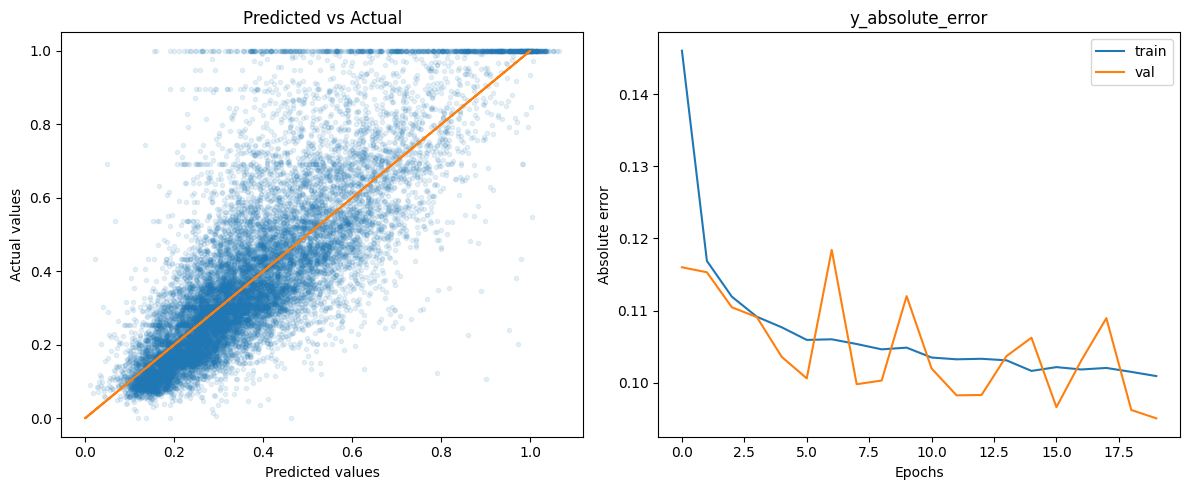

loss - 0.01999738998711109
mean_absolute_error - 0.10091550648212433
mean_absolute_percentage_error - 68784.4296875
val_loss - 0.018330741673707962
val_mean_absolute_error - 0.09505453705787659
val_mean_absolute_percentage_error - 29.884735107421875
relu
INFO:tensorflow:Assets written to: saved_models/[64, 64, 32, 16, 8, 4, 2, 1]-relu\assets


INFO:tensorflow:Assets written to: saved_models/[64, 64, 32, 16, 8, 4, 2, 1]-relu\assets


484/484 [==============================] - 1s 1ms/step


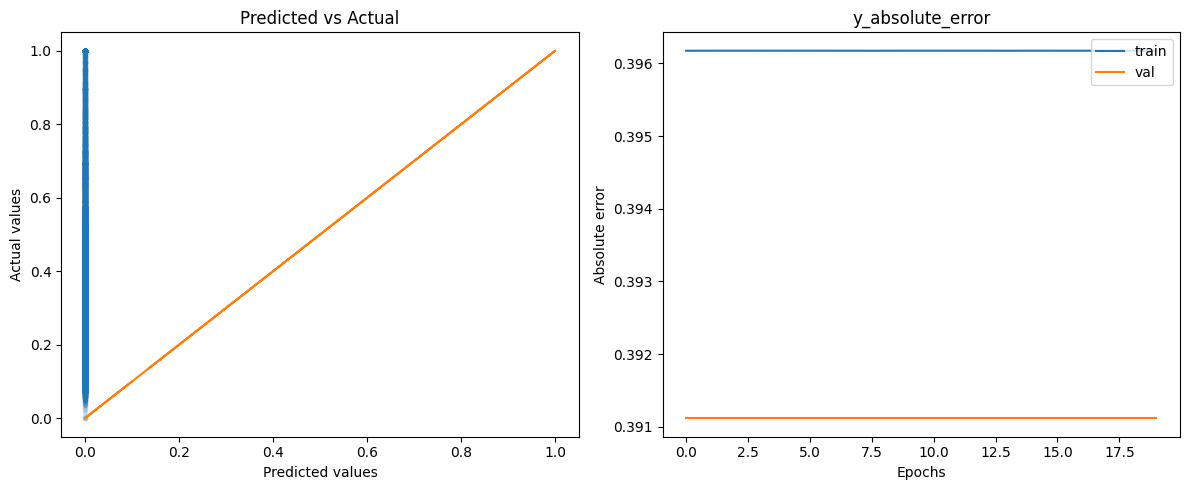

loss - 0.21374909579753876
mean_absolute_error - 0.3961741030216217
mean_absolute_percentage_error - 99.9712905883789
val_loss - 0.21091294288635254
val_mean_absolute_error - 0.391117662191391
val_mean_absolute_percentage_error - 100.0
leaky_relu
INFO:tensorflow:Assets written to: saved_models/[64, 64, 32, 16, 8, 4, 2, 1]-leaky_relu\assets


INFO:tensorflow:Assets written to: saved_models/[64, 64, 32, 16, 8, 4, 2, 1]-leaky_relu\assets


484/484 [==============================] - 1s 1ms/step


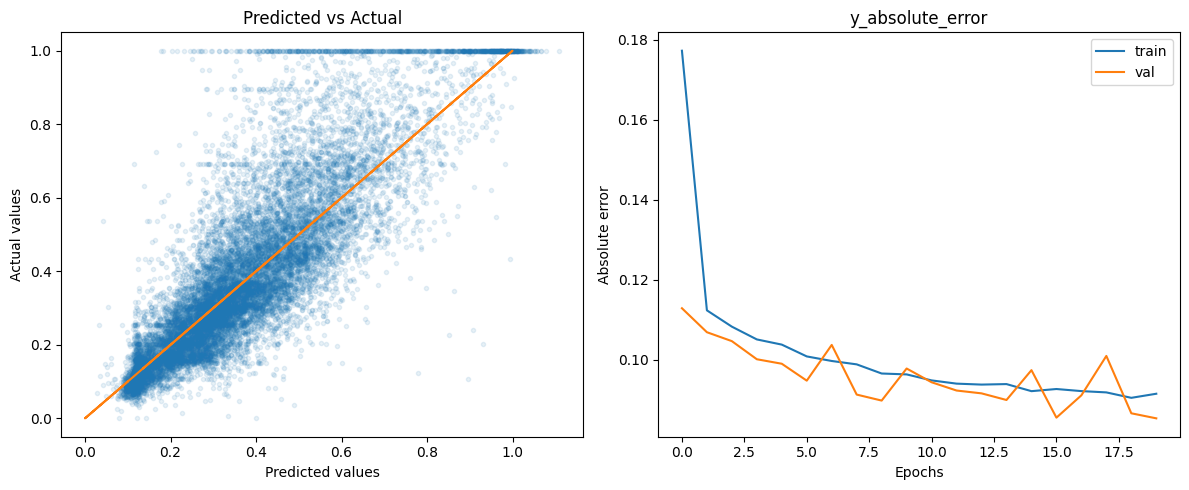

loss - 0.017086908221244812
mean_absolute_error - 0.09155277162790298
mean_absolute_percentage_error - 56619.578125
val_loss - 0.015742260962724686
val_mean_absolute_error - 0.08541033416986465
val_mean_absolute_percentage_error - 25.368602752685547
tanh
INFO:tensorflow:Assets written to: saved_models/[64, 64, 32, 16, 8, 4, 2, 1]-tanh\assets


INFO:tensorflow:Assets written to: saved_models/[64, 64, 32, 16, 8, 4, 2, 1]-tanh\assets


484/484 [==============================] - 1s 1ms/step


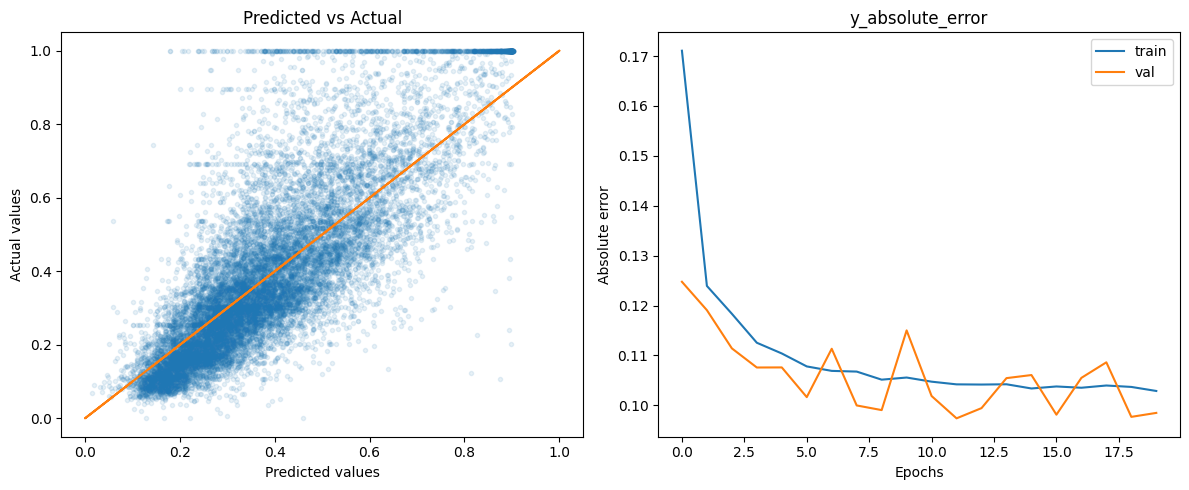

loss - 0.020326899364590645
mean_absolute_error - 0.10287777334451675
mean_absolute_percentage_error - 70467.1875
val_loss - 0.018834980204701424
val_mean_absolute_error - 0.09848245978355408
val_mean_absolute_percentage_error - 31.946062088012695


In [56]:
l = [64, 64, 32, 16, 8, 4, 2, 1]
optimizer = tf.keras.optimizers.legacy.Adam()
metrics = ['mean_absolute_error','mean_absolute_percentage_error']
evaluate_layer_architecture(l, activation_functions, 20, metrics, [x_train_n, y_train_n])

#### ELU with Large Neural Network

In [14]:
# define the keras model
layer_sizes = [256, 512, 1024, 512, 256, 128, 64, 32, 16, 8, 4, 2, 1]
activation = 'elu'
epochs = 200
optimizer = tf.keras.optimizers.Adam()
metrics = ['mean_absolute_error','mean_absolute_percentage_error']
model_name = 'model1_adam'

model, history = create_and_train_model(layer_sizes, activation, epochs, optimizer, metrics, model_name)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               2304      
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dense_2 (Dense)             (None, 1024)              525312    
                                                                 
 dense_3 (Dense)             (None, 512)               524800    
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dense_6 (Dense)             (None, 64)                8

KeyboardInterrupt: 

In [15]:
plot_training_history('mean_absolute_error', 'val_mean_absolute_error', history, title='y_absolute_error')

NameError: name 'history' is not defined

In [79]:
labels_predicted = model.predict(x_train_n)

484/484 [==============================] - 4s 9ms/step


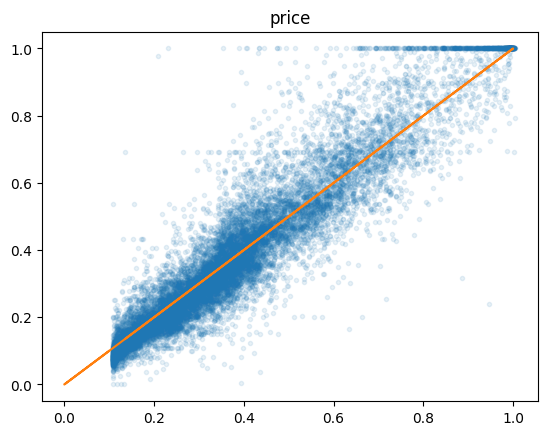

In [80]:
visualize_predictions(labels_predicted, y_train_n)

### sELU with Smaller Network


In [72]:
layer_sizes = [64, 64, 32, 16, 8, 4, 2, 1]
activation = 'selu'
#model = load_model("models/full_20231018_adam")
 
model = initialize_sequential_model(layer_sizes, activation)
model.summary()
model.compile(loss='mean_squared_error', 
              optimizer= tf.keras.optimizers.Adam(),  #"adam" 
              metrics=['mean_absolute_error','mean_absolute_percentage_error']
             )
# fit the keras model on the dataset
history = model.fit(x_train_n[:,:], #training data
                    y_train_n[:],  #Labels
                    epochs=200,
                    batch_size=128,
                    verbose=1,
                    validation_split = 0.1
                   )
model.save("model2_adam")

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_99 (Dense)            (None, 64)                576       
                                                                 
 dense_100 (Dense)           (None, 64)                4160      
                                                                 
 dense_101 (Dense)           (None, 32)                2080      
                                                                 
 dense_102 (Dense)           (None, 16)                528       
                                                                 
 dense_103 (Dense)           (None, 8)                 136       
                                                                 
 dense_104 (Dense)           (None, 4)                 36        
                                                                 
 dense_105 (Dense)           (None, 2)               

INFO:tensorflow:Assets written to: model2_adam\assets


In [73]:
evaluate_model_on_final_epoch(history)

loss - 0.011878125369548798
mean_absolute_error - 0.07428022474050522
mean_absolute_percentage_error - 46099.66015625
val_loss - 0.011040359735488892
val_mean_absolute_error - 0.07201238721609116
val_mean_absolute_percentage_error - 22.783967971801758


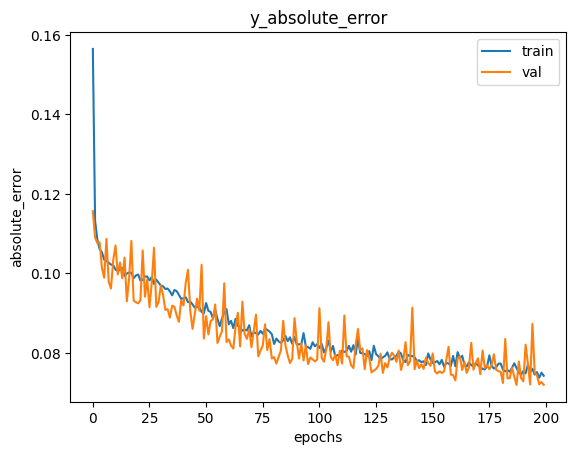

In [74]:
plot_training_history('mean_absolute_error', 'val_mean_absolute_error', history, title='y_absolute_error')

In [75]:
labels_predicted = model.predict(x_train_n)

484/484 [==============================] - 1s 895us/step


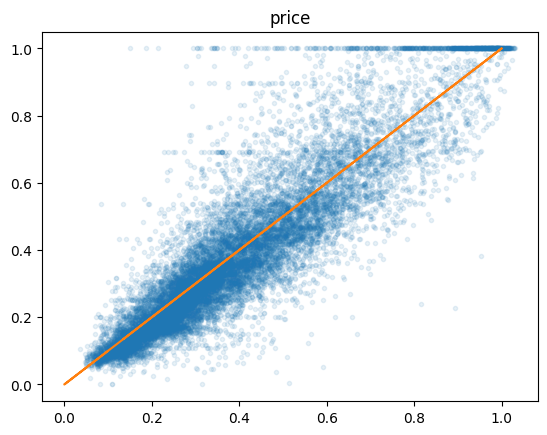

In [76]:
visualize_predictions(labels_predicted, y_train_n)